In [4]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import cv2

from skimage.io import imread
from skimage.data import shepp_logan_phantom
from skimage.transform import iradon, iradon_sart, radon, rescale

import pickle
import os
import multiprocessing as mp
import glob

import time

### Multi-threaded reading of view measurements from csv

In [5]:
dose=280 #020, 080 or 280 at the moment
views_location=f"/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose{dose}/out"

In [7]:
def set_strip(inp):
    (csv_path, idx, shared_list, do_exp)=inp
    try:
        arr=np.genfromtxt(csv_path,delimiter=',')
        if do_exp:
            arr=np.exp(arr)
            arr=np.clip(arr,0,255)
            arr=np.uint8(arr)
        else:
            arr=(arr-np.min(arr))/(np.max(arr)-np.min(arr))*255
        im=Image.fromarray(arr)
        shared_list[idx]=im
    except:
        print(f"ERROR in file {csv_path}")

def get_strips(do_exp=False, max_cnt=None):
    cnt=0
    csv_paths=sorted(glob.glob(f"{views_location}/*.csv"),key=lambda x:int(x[59:-4]))
    if not max_cnt:
        max_cnt=len(csv_paths)

    start = time.time()
    print("Reading of input started")
    print(f"It will take approximately {5.0*max_cnt/len(csv_paths)} minutes")

    with mp.Manager() as manager:    
        strips = mp.Manager().list([None]*max_cnt)
        pool = mp.Pool(mp.cpu_count())
        pool.map(set_strip, zip(csv_paths[:max_cnt],range(max_cnt),[strips]*max_cnt,[do_exp]*max_cnt))

    strips=list(strips)
    strips=list(filter(None, strips))

    end = time.time()
    print("Reading of input has finished")
    print(f"{len(strips)} views were read")
    print(f"It took {(end - start)/60} minutes")
    
    return strips

In [8]:
strips=get_strips(max_cnt=20000)

Reading of input started
It will take approximately 2.066457265663746 minutes
Reading of input has finished
20000 views were read
It took 1.8002599755922952 minutes


### Create sinogram from views

In [9]:
ANGLES=720*2*2 #Number of views to use for a sinogram
HALF_ANGLES=ANGLES//2
PROJECTIONS=896
HALF_PROJECTIONS=PROJECTIONS//2
START_PERIOD=4 #From where to take the views for the sinogram. If x, then view number x*ANGLES is the first view to use.
SMALL_R=518
BIG_R=910
FULL_CIRCLE=2*math.pi
SEMI_CIRCLE=FULL_CIRCLE/2

In [10]:
MAX_DISPLACEMENT=math.sqrt(SMALL_R**2-(BIG_R/2)**2)
HALF_VIEW_ANGLE=math.asin(MAX_DISPLACEMENT/SMALL_R)
VIEW_ANGLE=2*HALF_VIEW_ANGLE

In [11]:
def plot_sinogram(sinogram, method, angle_range):
    plt.figure()
    plt.title(method)
    plt.xlabel('angle (pixel)')
    plt.ylabel('projection (pixel)')
    np.arange(0.0, angle_range, step=30.0)
    plt.imshow(sinogram,cmap=plt.cm.Greys_r)

In [25]:
def create_sinogram_stupid_360(strips, shift=0):
    sinogram = Image.new('L', (ANGLES,PROJECTIONS))
    for idx in range(START_PERIOD*ANGLES+shift,(START_PERIOD+1)*ANGLES+shift):
        strip=Image.fromarray(np.expand_dims(np.mean(np.array(strips[idx]),axis=0),axis=1))
        i=idx-(START_PERIOD*ANGLES+shift)
        sinogram.paste(strip, (i, 0))
    plot_sinogram(sinogram,"sinogram_stupid_360",360)
    return sinogram

In [13]:
def create_sinogram_stupid_180(strips):
    sinogram = Image.new('L', (HALF_ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=(idx-START_PERIOD*ANGLES)
        for j in range(PROJECTIONS):
            if(i<HALF_ANGLES):
                pixels[i,j]+=int(strip[j]/2)
            else:
                pixels[i-HALF_ANGLES,PROJECTIONS-j-1]+=int(strip[j]/2)
    plot_sinogram(sinogram,"sinogram_stupid_180",180)
    return sinogram

In [14]:
def create_sinogram_stupid_full(strips):
    num=len(strips)
    sinogram = Image.new('L', (PROJECTIONS, num))
    for i in range(num):
        strip=Image.fromarray(np.expand_dims(np.mean(np.array(strips[i]),axis=0),axis=1))
        sinogram.paste(strip, (i, 0))
    plot_sinogram(sinogram,"sinogram_stupid_full",num)
    return sinogram

In [15]:
def create_sinogram_intuitive_360(strips):
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(i+j)%ANGLES,j]=int(strip[j])
    plot_sinogram(sinogram,"sinogram_intuitive_360",360)
    return sinogram

In [16]:
def create_sinogram_intuitive_180(strips):
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(i+j)%HALF_ANGLES,j]=int(strip[j]/2)
    plot_sinogram(sinogram,"sinogram_intuitive_180",180)
    return sinogram

In [17]:
def create_sinogram_intuitive_param_180(strips,slope):
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(i+j*slope)%HALF_ANGLES,j]=int(strip[j]/2)
    plot_sinogram(sinogram,"sinogram_intuitive_180",180)
    return sinogram

In [18]:
def my_round(v,maxi):
    return min(maxi-1,round(v))

In [19]:
def create_sinogram_trigonometry_360(strips):
    
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))#,color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,HALF_PROJECTIONS,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.min(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]+displacement_angles[j])%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS+HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS+j])
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]-displacement_angles[j]+FULL_CIRCLE)%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS-HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS-j])
    
    
    plot_sinogram(sinogram, "sinogram_trigonometry_360",360)
    return sinogram

In [20]:
def create_sinogram_trigonometry_180(strips):
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS))#,color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,HALF_PROJECTIONS,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]+displacement_angles[j])%FULL_CIRCLE
            angle_pixel=my_round(HALF_ANGLES*angle_rad/FULL_CIRCLE,HALF_ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS+HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]+=int(strip[HALF_PROJECTIONS+j]/2)
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]-displacement_angles[j]+FULL_CIRCLE)%FULL_CIRCLE
            angle_pixel=my_round(HALF_ANGLES*angle_rad/FULL_CIRCLE,HALF_ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS-HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]+=int(strip[HALF_PROJECTIONS-j]/2)
    plot_sinogram(sinogram, "sinogram_trigonometry_180",180)
    return sinogram

### Comparing methods

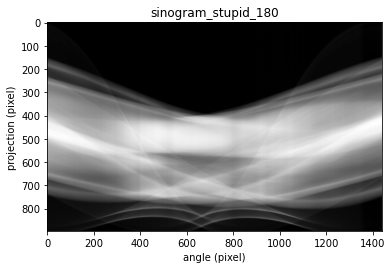

In [17]:
sinogram=create_sinogram_stupid_180(strips)

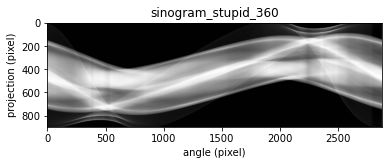

In [18]:
sinogram=create_sinogram_stupid_360(strips)

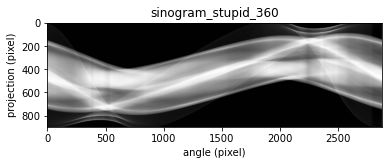

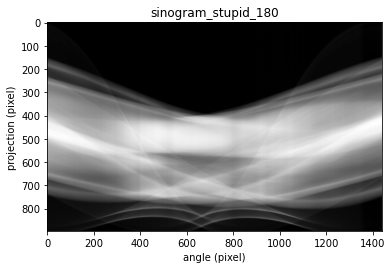

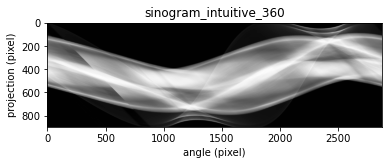

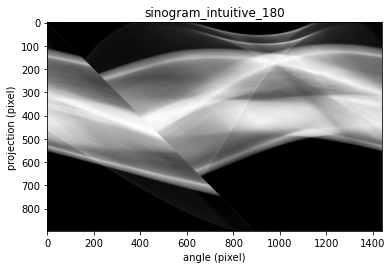

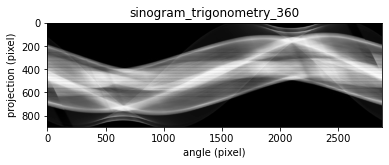

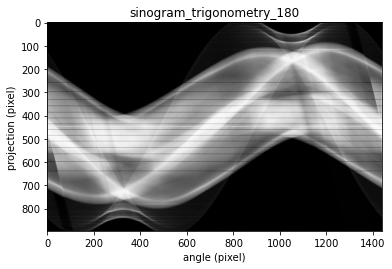

In [19]:
for method in [create_sinogram_stupid_360, create_sinogram_stupid_180, create_sinogram_intuitive_360, create_sinogram_intuitive_180, create_sinogram_trigonometry_360, create_sinogram_trigonometry_180]:
    method(strips)

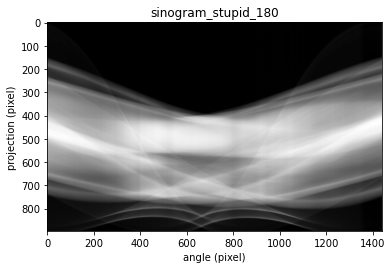

In [35]:
sinogram=create_sinogram_stupid_180(strips)

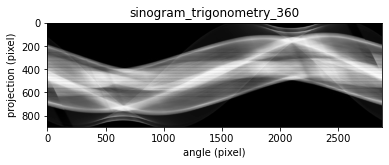

In [31]:
sinogram=create_sinogram_trigonometry_360(strips)

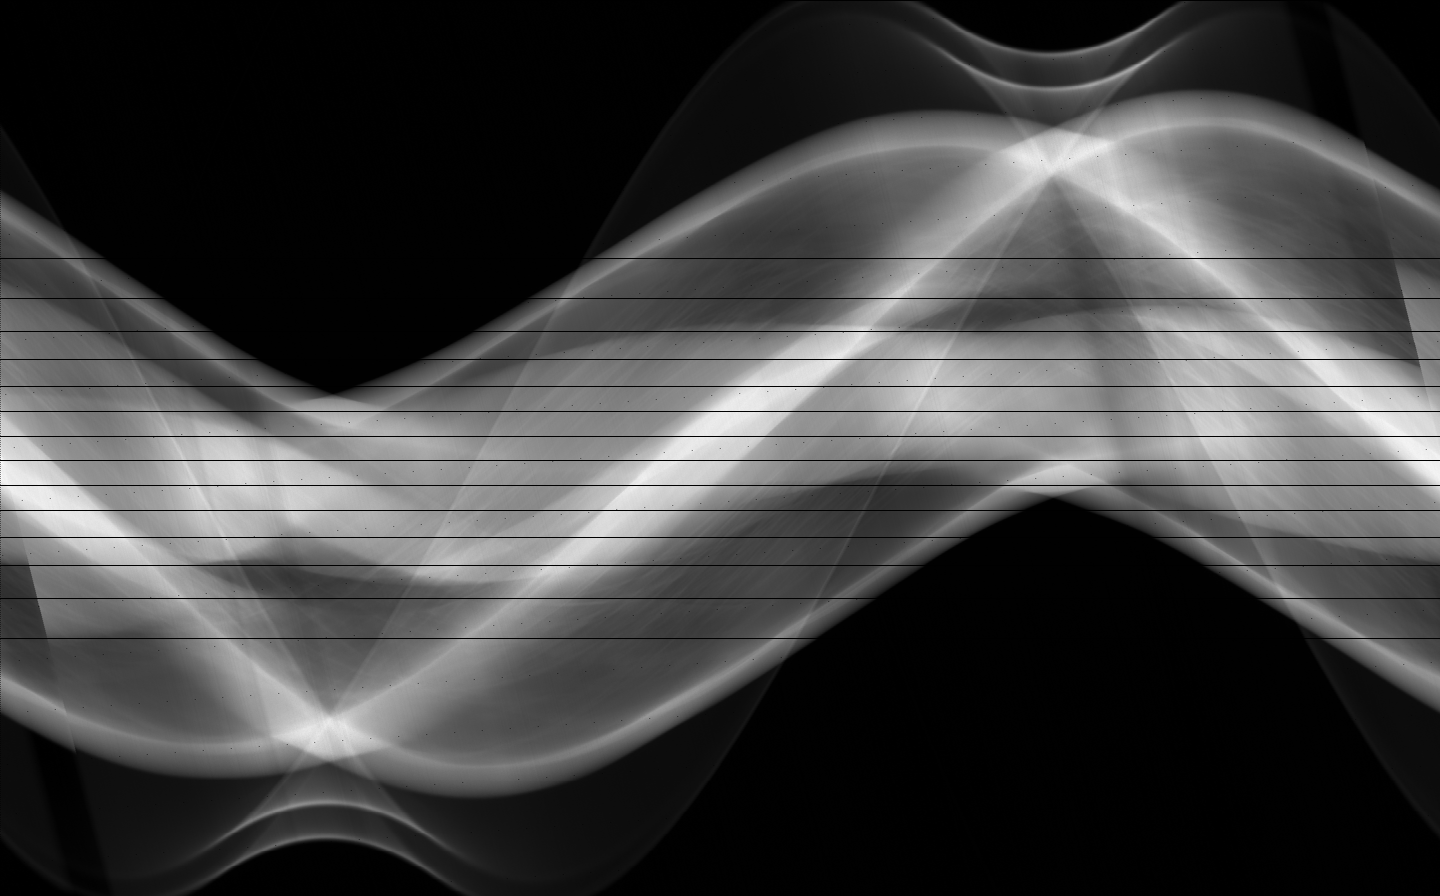

In [22]:
sinogram.resize((1440, 896), Image.BICUBIC)

## Image restoration / interpolation

In [113]:
def remove_horizontal_lines(sinogram): #Might be needed if using trigonometry and rounding
    gray = np.array(sinogram)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
    horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(gray, [c], -1, 255, 2)

    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 6))

    result = 255 - cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel,
    iterations=1)

    plt.imshow(result, cmap = 'gray')#, interpolation = 'bicubic')
    return result

In [114]:
def remove_horizontal_lines2(sinogram):
    gray = np.array(sinogram)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    #print(detected_lines)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(gray, [c], -1, 255, 2)

    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    result = 255 - cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

    plt.imshow(result, cmap = 'gray')
    plt.imshow(detected_lines, cmap='gray')
    return result

In [115]:
def remove_horizontal_lines3(sinogram):
    gray = np.array(sinogram)
    edges = cv2.Canny(gray,50,150,apertureSize = 3)
    lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=100,maxLineGap=80)
    a,b,c = lines.shape
    for i in range(a):
        #TODO: instead should smooth/interpolate these lines, not draw them in black, but I don't know how to do it.
        cv2.line(gray, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 3, cv2.LINE_AA)
    plt.imshow(gray, cmap='gray')

array([[255, 255,   0, ...,   0, 255, 255],
       [255, 255,   0, ...,   0, 255, 255],
       [255, 255,   0, ...,   0, 255, 255],
       ...,
       [255, 255,   0, ...,   0, 255, 255],
       [255, 255,   0, ...,   0, 255, 255],
       [255, 255,   0, ...,   0, 255, 255]], dtype=uint8)

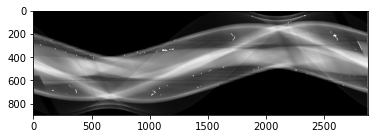

In [116]:
remove_horizontal_lines(sinogram)

In [87]:
remove_horizontal_lines3(sinogram)

In [ ]:
sinogram.resize((45, 56), Image.BICUBIC)

In [ ]:
sinogram.filter(ImageFilter.GaussianBlur(1))

In [ ]:
sinogram.filter(ImageFilter.SMOOTH_MORE)

## Save nice results

In [ ]:
sinogram.save(f"/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose{dose}/best_sinogram.jpg")

## Inverse Radon

In [37]:
theta = np.linspace(0, 360, 2880, endpoint=False)
#theta = np.linspace(0, 180, 1440, endpoint=False)
reconstruction_fbp = iradon(np.array(sinogram),theta=theta, output_size=512)#, circle=True)

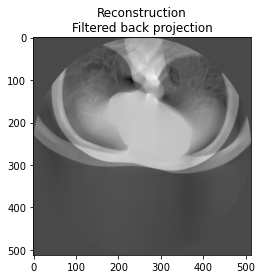

In [38]:
plt.title("Reconstruction\nFiltered back projection")
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.show()

## Further experiment

### Adding shift

0


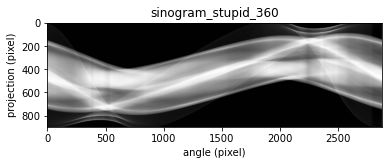

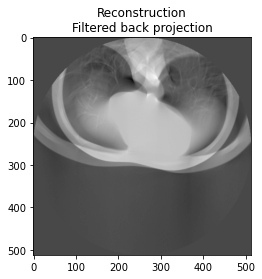

320


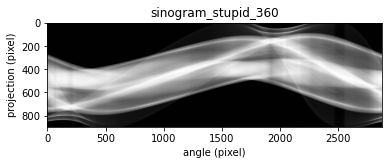

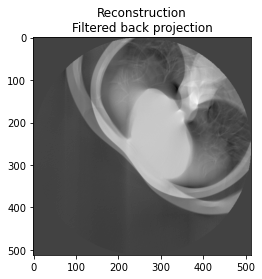

640


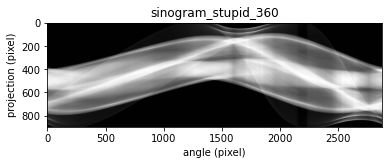

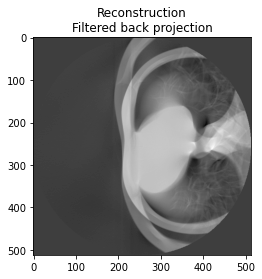

960


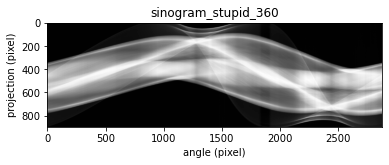

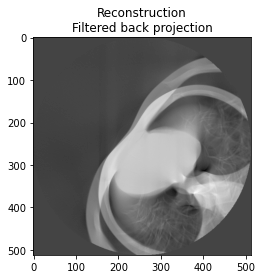

1280


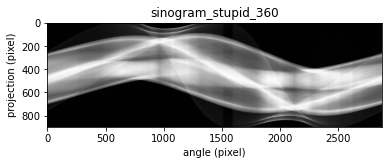

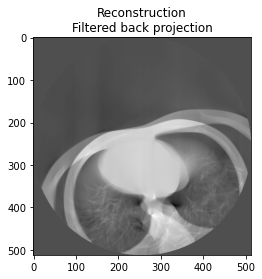

1600


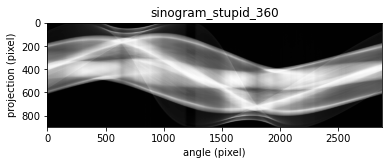

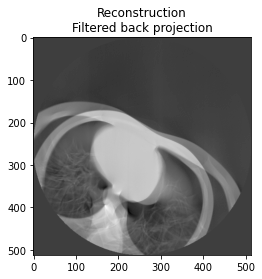

1920


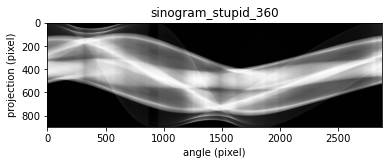

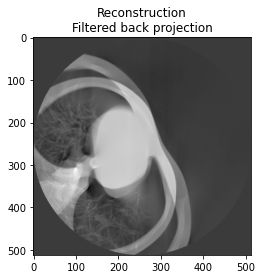

2240


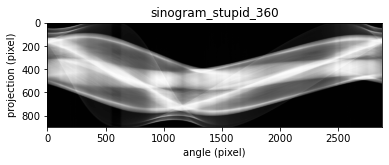

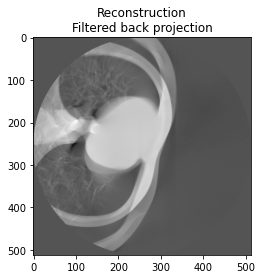

2560


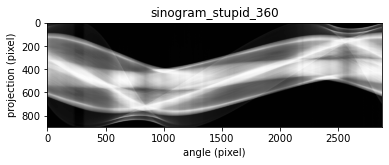

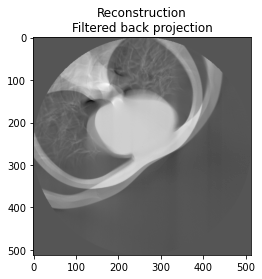

2880


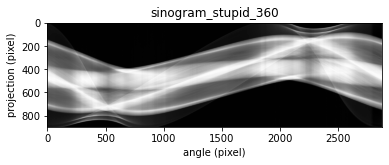

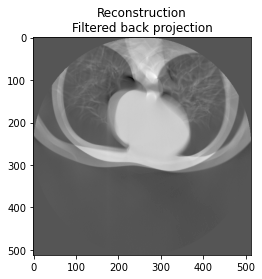

In [30]:
for i in np.asarray(np.linspace(0,2880,10)).astype(int):
    print(i)
    sinogram = create_sinogram_stupid_360(strips,shift=i)
    theta = np.linspace(0, 360, 2880, endpoint=False)
    reconstruction_fbp = iradon(np.array(sinogram),theta=theta, output_size=512)#, circle=True)
    
    plt.figure()
    plt.title("Reconstruction\nFiltered back projection")
    plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
    plt.show()